###Atharva Mankame [21BAI1780]


### Image classification using CNN


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D

In [ ]:
import os

labels_df = pd.read_csv('Imagelabels.csv').astype(str)
labels_df.head()

,labels
0,0
1,0
2,0
3,0
4,0


In [ ]:
# Generate a list of image filenames assuming a sequential naming pattern
image_folder = 'scalogram'
num_images = labels_df.shape[0]

image_filenames = [f"{i}" for i in os.listdir(image_folder)]  # Adjust based on your file naming
image_filenames = sorted(image_filenames, key=lambda x: int(x.split('_')[1].split('.')[0]))

# Combine into a new DataFrame
data_df = pd.DataFrame({
    'filename': image_filenames,
    'label': labels_df['labels']
})

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming `data_df` is your DataFrame with 'filename' and 'label'
X = data_df['filename']  # File paths
y = data_df['label']  # Corresponding labels

# Perform a stratified split to maintain label proportions in train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create new DataFrames for the split
train_df = pd.DataFrame({'filename': X_train, 'label': y_train})
val_df = pd.DataFrame({'filename': X_val, 'label': y_val})


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize ImageDataGenerator for training data (you can add data augmentation parameters here)
train_datagen = ImageDataGenerator(rescale=1./255.)

# Initialize ImageDataGenerator for validation data
val_datagen = ImageDataGenerator(rescale=1./255.)

# Create the train generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='scalogram',  # Adjust accordingly
    x_col='filename',
    y_col='label',
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode='categorical',
    target_size=(150, 150)  # Adjust as necessary
)

# Create the validation generator
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='scalogram',  # Adjust accordingly
    x_col='filename',
    y_col='label',
    batch_size=32,
    seed=42,
    shuffle=False,  # Typically not necessary to shuffle validation data
    class_mode='categorical',
    target_size=(150, 150)  # Adjust as necessary
)


Found 1280 validated image filenames belonging to 25 classes.
Found 320 validated image filenames belonging to 25 classes.


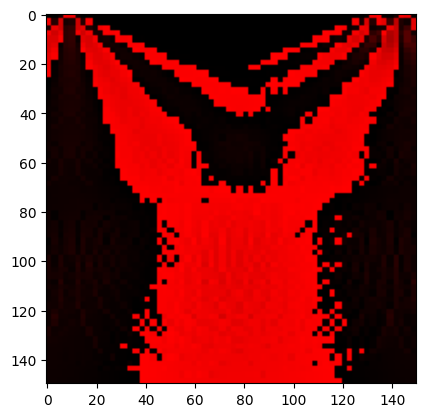

In [ ]:
plt.imshow(train_generator[0][0][2])

plt.show()

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(25, activation='softmax')
])

In [ ]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=25,
    min_delta=0.001
    )

In [ ]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer='Adam',
    metrics='accuracy'
)

In [ ]:
history = model.fit(train_generator,epochs=20,
          batch_size=6,
          validation_data=val_generator,
          callbacks=[early_stop]
          )

Epoch 1/20


40/40 [==============================] - 21s 482ms/step - loss: 3.0833 - accuracy: 0.1406 - val_loss: 2.5021 - val_accuracy: 0.2875
Epoch 2/20
40/40 [==============================] - 12s 303ms/step - loss: 2.1192 - accuracy: 0.4039 - val_loss: 1.8947 - val_accuracy: 0.4719
Epoch 3/20
40/40 [==============================] - 11s 278ms/step - loss: 1.5694 - accuracy: 0.5195 - val_loss: 1.6678 - val_accuracy: 0.5156
Epoch 4/20
40/40 [==============================] - 12s 290ms/step - loss: 1.2295 - accuracy: 0.6211 - val_loss: 1.6103 - val_accuracy: 0.5063
Epoch 5/20
40/40 [==============================] - 11s 278ms/step - loss: 0.9387 - accuracy: 0.6781 - val_loss: 1.7930 - val_accuracy: 0.5188
Epoch 6/20
40/40 [==============================] - 12s 291ms/step - loss: 0.6257 - accuracy: 0.7945 - val_loss: 2.2867 - val_accuracy: 0.5312
Epoch 7/20
40/40 [==============================] - 12s 300ms/step - loss: 0.4170 - accuracy: 0.8539 - val_loss: 2.0319 - val_accuracy: 0.52

Accuracy: 0.9624999761581421


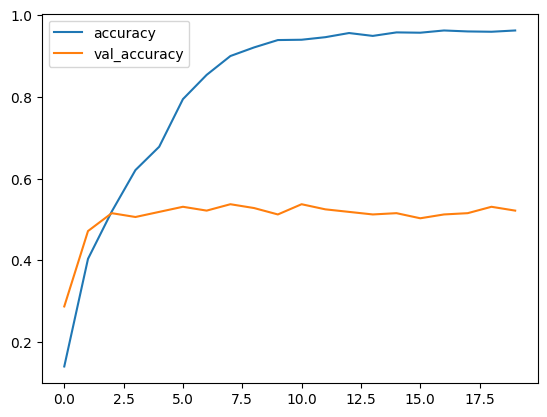

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy','val_accuracy']].plot()
print("Accuracy: {}".format(history_df['accuracy'].max()))

In [ ]:

predictions = model.predict(train_generator, steps=val_generator.samples // val_generator.batch_size)
predicted_classes = np.argmax(predictions, axis=1)

10/10 [==============================] - 1s 97ms/step


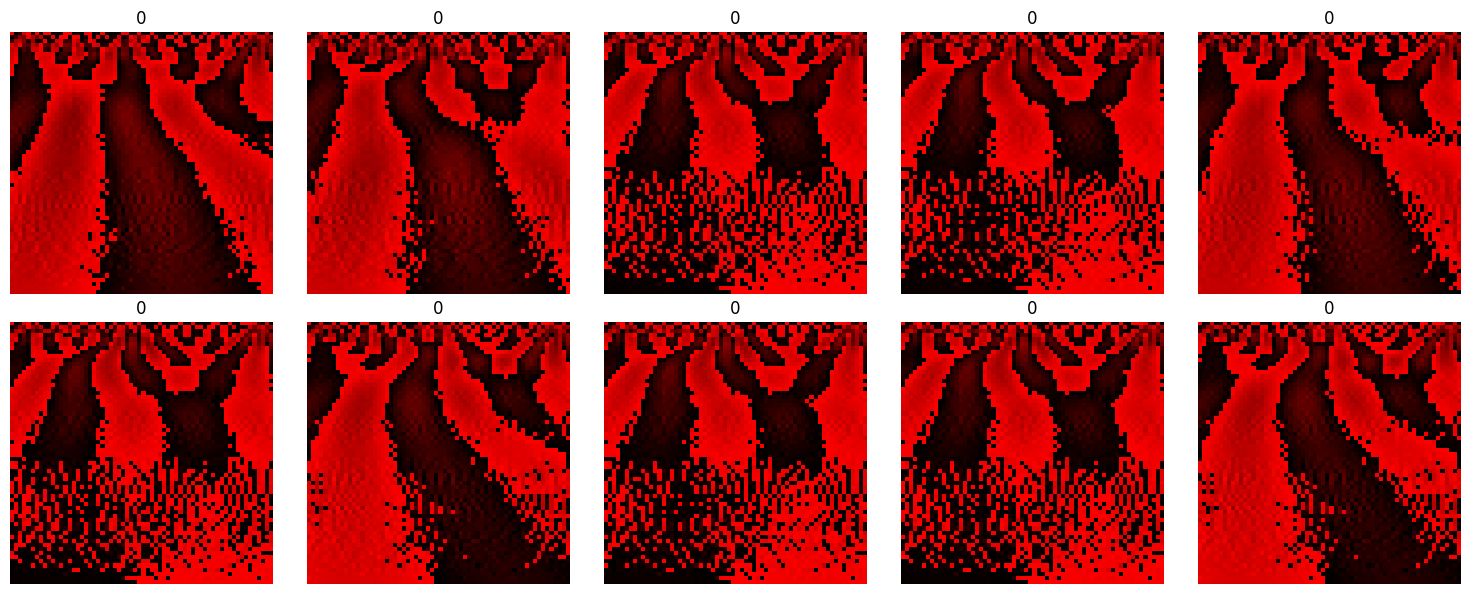

In [ ]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

path = 'scalogram/'
# Function to display a grid of images with labels
def display_images(data_df, rows=1, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        if i < len(data_df):
            img_path = data_df.iloc[i]['filename']
            label = data_df.iloc[i]['label']
            image = Image.open(path+str(img_path))
            ax.imshow(image)
            ax.set_title(label)
            ax.axis('off')
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage
display_images(data_df, rows=2, cols=5)


In [ ]:
# Assuming 'test_generator' is prepared similarly to 'train_generator' but with test data
test_loss, test_acc = model.evaluate(val_generator)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")


10/10 [==============================] - 1s 77ms/step - loss: 2.7773 - accuracy: 0.5219
Test Loss: 2.7773303985595703
Test Accuracy: 0.5218750238418579
